# Exploratory Data Analysis - covariants
by __Pawel Rosikiewicz__ 

---

## Setup
---

__global imports__
* I purposely placed other imports, such as my custom made functions for thsi project in each section
* to allow you fast inspection of my code, but also, copying these important to new notebooks, for pipeline development

In [1]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn import set_config
from sklearn.preprocessing import RobustScaler # creates custom transfomers
from sklearn.preprocessing import FunctionTransformer # creates custom transfomers
from sklearn.pipeline import make_pipeline, Pipeline # like pipeline function, but give step names automatically, 
from sklearn.compose import ColumnTransformer # allows using different transformers to different columns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer # skleanr transformers,
from sklearn.decomposition import PCA

In [2]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

In [3]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

__load functions, and classes created for that project__

In [4]:
from src.utils.helper_data_loaders import load_tsv
from src.utils.PREPROCESSING_PIPELINE01 import data_preprocessing_pipeline

__configurations__

In [5]:
# main variable groups, and types
VAR_GROUPS = dict(
    TARGET_VAR = ["target"],
    CATEGORICAL_VAR = [ 'Baseline ECOG Score', 'Enrollment IC', 'IC Level', 'TC Level', 'Immune phenotype', 'Sex',
           'TCGA Subtype', 'Lund', 'Lund2', 'Received platinum',
           'Met Disease Status', 'Sample age', 'Sample collected pre-platinum',
           'Intravesical BCG administered', 'Tobacco Use History'],
    QUANTITATIVE_VAR = ['FMOne mutation burden per MB', 'Neoantigen burden per MB'],
)

# variable encoding in data_cov
VAR_DTYPES = {
    "TARGET_VAR": "int", # only for EDA
    "CATEGORICAL_VAR": "O",
    "QUANTITATIVE_VAR": "float64"
}

# target variable encoding
TARGET_ENCODING = {0:"non-responder", 1:"responder"}

# list potential confounding variables, used to stratify the results
CONFOUNDING_VAR = ['Sex', 'Tobacco Use History']

## PART 1. Load the data

In [6]:
# load target data
data_cov =  load_tsv(PATH_data_raw, 'X_covariates.tsv')
data_genes = load_tsv(PATH_data_raw, 'X_genes.tsv')
data_cov_test =  load_tsv(PATH_data_raw, 'X_covariates_test.tsv')
data_genes_test = load_tsv(PATH_data_raw, 'X_genes_test.tsv')
target = load_tsv(PATH_data_raw, 'y.tsv', header=None)

# small correction
target.columns=[VAR_GROUPS["TARGET_VAR"][0]]
target = pd.Series(target.iloc[:,0])

(200, 17)
(200, 31085)
(98, 17)
(98, 31085)
(200, 1)


In [7]:
# inspect
print("shape:", data_genes.shape)
print("missing data nr:", data_genes.isnull().sum().sum())

# get example
data_genes.head()

shape: (200, 31085)
missing data nr: 0


,TPM_hugo_A1BG,TPM_hugo_A1BG-AS1,TPM_hugo_A1CF,TPM_hugo_A2M,TPM_hugo_A2M-AS1,TPM_hugo_A2ML1,TPM_hugo_A2MP1,TPM_hugo_A3GALT2,TPM_hugo_A4GALT,TPM_hugo_A4GNT,...,TPM_hugo_ZWILCH,TPM_hugo_ZWINT,TPM_hugo_ZXDA,TPM_hugo_ZXDB,TPM_hugo_ZXDC,TPM_hugo_ZYG11A,TPM_hugo_ZYG11B,TPM_hugo_ZYX,TPM_hugo_ZZEF1,TPM_hugo_ZZZ3
0,1.564289,2.711834,0.0,599.387994,2.354073,43.245808,0.0,0.000000,11.437090,0.070903,...,8.574489,6.467672,1.906227,3.293924,8.333586,2.189232,19.280571,168.266220,27.175332,17.836860
1,3.487859,1.717013,0.0,222.711937,2.288359,5.718716,0.0,0.564476,6.026609,0.108688,...,10.409939,3.572365,2.761780,3.411667,9.293182,1.813353,21.761841,66.403339,21.311923,22.296492
2,0.613334,0.508520,0.0,204.222937,0.627338,300.472716,0.0,0.000000,11.797474,0.040773,...,6.272013,3.109443,1.068439,2.559726,5.181549,0.225283,15.800051,172.944084,14.743828,18.920023
3,2.385017,1.600782,0.0,1851.589619,3.301540,1.346349,0.0,0.000000,23.938826,0.000000,...,4.586123,1.150169,1.464567,1.386418,4.501980,0.036808,11.444219,116.271619,19.222790,11.936066
4,1.964353,0.791064,0.0,982.752783,0.589165,85.088254,0.0,0.096887,17.058419,0.447727,...,4.292896,2.469881,1.809374,3.056738,6.604204,0.436553,20.036719,143.793153,24.820985,17.297542


In [28]:
# input data
df = data_cov.copy()

# inputs
numeric_features = VAR_GROUPS["QUANTITATIVE_VAR"].copy()

# find all other features in input data
all_other_features = df.columns.values.tolist()
for v in numeric_features:
    try:
        all_other_features.remove(v)
    except:
        pass
    
# create custom transformer
log_scale_transformer = make_pipeline( 
    FunctionTransformer(np.abs, validate=False),   
    FunctionTransformer(np.log1p, validate=False), # creates runtime warning if negative data are used
    StandardScaler()
)

# create data preprocessor for numeric features
numeric_transformer = Pipeline(steps=[
        ("imputer",SimpleImputer(strategy='mean')), 
        ("scaler",StandardScaler())
    ])

# create data preprocessor for numeric features
categorical_transformer = Pipeline(steps=[
        ("first_imputer",SimpleImputer(strategy='most_frequent')),
        ("onehot", OneHotEncoder(handle_unknown='ignore')), 
    ]) # drop='first', 
    # comment: you can drop first and ignore new, following: 
    # .. https://scikit-learn.org/stable/developers/advanced_installation.html

# preprocessor for all the data
''' ColumnTransformer: it allows apllying different tranfomers to different columns
    - give unique names for each transformer
    - passthrough - keyword, nothing is done with that column
    - column names are always provided as LIST
'''
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers = [
            ("numeric_features", numeric_transformer, numeric_features),
            ("other_features", categorical_transformer, all_other_features), # "passthrough" other option,     
        ], 
        remainder='drop'
    ))

# check if everythign is ok
set_config(display="diagram") # or "text"
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['FMOne mutation burden per '
                                                   'MB',
                                                   'Neoantigen burden per MB']),
                                                 ('other_features',
                                                  Pipeline(steps=[('first_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Enrollment IC', 'IC Level',
                                                   'TC Level',
                                                   'Immune phenotype', 'Sex',
                                                   'TCGA Subtype', 'Lund',
                                                   'Lund2', 'Received platinum',
                                                   'Met Disease Status',
                                                   'Sample age',
                                                   'Sample collected '
                                                   'pre-platinum',
                                                   'Intravesical BCG '
                                                   'administered',
                                                   'Baseline ECOG Score',
                                                   'Tobacco Use History'])]))])

In [29]:
# test
eg = preprocessor.fit_transform(data_cov.iloc[0:40, :])
eg2 = preprocessor.transform(data_cov_test)

print(eg.shape, eg2.shape)

(40, 50) (98, 50)


In [30]:
# parameters for data preparation
parameters = {
    'Signif_genes':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=0.95, quantile=True),
        'select_genes_dct':dict(Log2FCtr=0.5, Ptr=0.05, create_plot=True),
        'pca_n_components':0
     },
    'Signif_genes_PCA':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=0.95, quantile=True),
        'select_genes_dct':dict(Log2FCtr=0.5, Ptr=0.05, create_plot=True),
        'pca_n_components':None
     },    
    'DE_genes_PCA':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=0.95, quantile=True),
        'select_genes_dct':dict(Log2FCtr=0.2, Ptr=0.2, create_plot=True),
        'pca_n_components':None
     }    
}

140
40


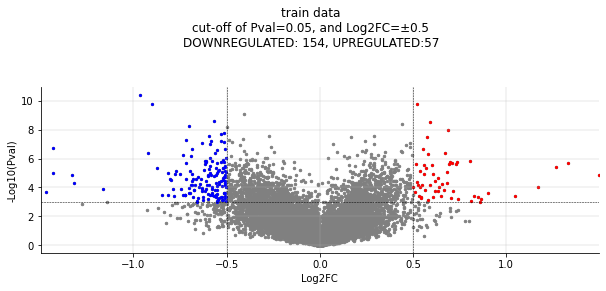


............................................................
 train - Step 1-5
............................................................



,input,log,log_filtered,log_filtered_scaled,outliers_removed,top_genes,after pca
sample nr,160,160,160,160,152,152,152
gene nr,31085,31085,18534,18534,18534,211,211
- VALUES -,,,,,,,
min tpm value recorded,0.0,0.0,0.0,-8.7,-8.7,-4.1,-4.1
median tpm value recorded,0.3,0.4,2.9,-0.0,0.0,0.0,0.0
mean tpm value recorded,32.2,1.8,3.1,0.1,0.1,0.1,0.1
max tpm value recorded,314419.1,18.3,18.3,336.7,336.7,25.2,25.2
- DETECTED IN -,,,,,,,
mean % of genes expressed per sample,60.1%,60.1%,95.9%,100.0%,100.0%,100.0%,100.0%
% of genes not expressed in any sample,18.2%,18.2%,0.0%,0.0%,0.0%,0.0%,0.0%


............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 211 
differencially expressed genes
............................................................


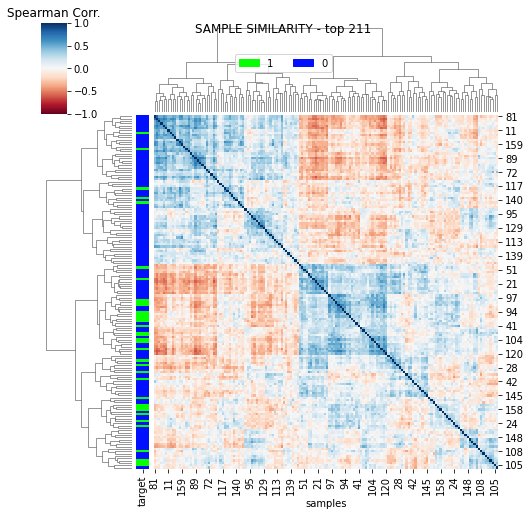

............................................................
GENE EXPRESSION IN THE TOP 
 211 differencially expressed genes
............................................................


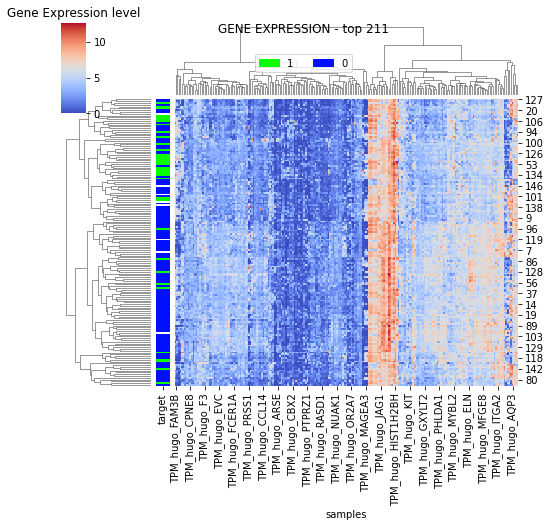

............................................................
PCA and tSNE analysis
............................................................


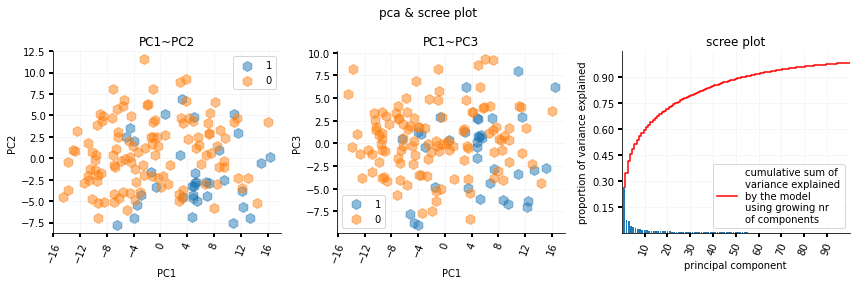


............................................................
 test0 - Step 1-5
............................................................



,input,log,log_filtered,log_filtered_scaled,outliers_removed,top_genes,after pca
sample nr,40,40,40,40,40,40,40
gene nr,31085,31085,18534,18534,18534,211,211
- VALUES -,,,,,,,
min tpm value recorded,0.0,0.0,0.0,-6.9,-6.9,-3.3,-3.3
median tpm value recorded,0.3,0.4,2.9,-0.0,-0.0,-0.0,-0.0
mean tpm value recorded,32.2,1.8,3.1,0.1,0.1,0.0,0.0
max tpm value recorded,98876.1,16.6,16.6,155.9,155.9,10.2,10.2
- DETECTED IN -,,,,,,,
mean % of genes expressed per sample,59.9%,59.9%,95.7%,100.0%,100.0%,100.0%,100.0%
% of genes not expressed in any sample,22.8%,22.8%,0.0%,0.0%,0.0%,0.0%,0.0%



............................................................
 test1 - Step 1-5
............................................................



,input,log,log_filtered,log_filtered_scaled,outliers_removed,top_genes,after pca
sample nr,98,98,98,98,98,98,98
gene nr,31085,31085,18534,18534,18534,211,211
- VALUES -,,,,,,,
min tpm value recorded,0.0,0.0,0.0,-6.9,-6.9,-3.4,-3.4
median tpm value recorded,0.3,0.4,2.9,0.0,0.0,-0.0,-0.0
mean tpm value recorded,32.2,1.8,3.1,0.1,0.1,0.1,0.1
max tpm value recorded,133685.0,17.0,17.0,171.3,171.3,14.0,14.0
- DETECTED IN -,,,,,,,
mean % of genes expressed per sample,60.4%,60.4%,96.1%,100.0%,100.0%,100.0%,100.0%
% of genes not expressed in any sample,19.6%,19.6%,0.0%,0.0%,0.0%,0.0%,0.0%


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  Signif_genes_v0__transf_data_dct.p
SAVED:  Signif_genes_v0__qc_reports_dct.p


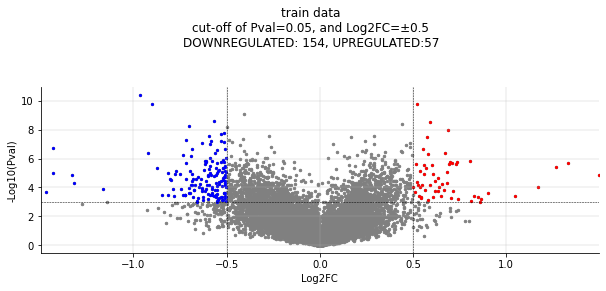


............................................................
 train - Step 1-5
............................................................



,input,log,log_filtered,log_filtered_scaled,outliers_removed,top_genes,after pca
sample nr,160,160,160,160,152,152,152
gene nr,31085,31085,18534,18534,18534,211,152
- VALUES -,,,,,,,
min tpm value recorded,0.0,0.0,0.0,-8.7,-8.7,-4.1,-10.7
median tpm value recorded,0.3,0.4,2.9,-0.0,0.0,0.0,-0.0
mean tpm value recorded,32.2,1.8,3.1,0.1,0.1,0.1,0.0
max tpm value recorded,314419.1,18.3,18.3,336.7,336.7,25.2,22.0
- DETECTED IN -,,,,,,,
mean % of genes expressed per sample,60.1%,60.1%,95.9%,100.0%,100.0%,100.0%,100.0%
% of genes not expressed in any sample,18.2%,18.2%,0.0%,0.0%,0.0%,0.0%,0.0%


............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 211 
differencially expressed genes
............................................................


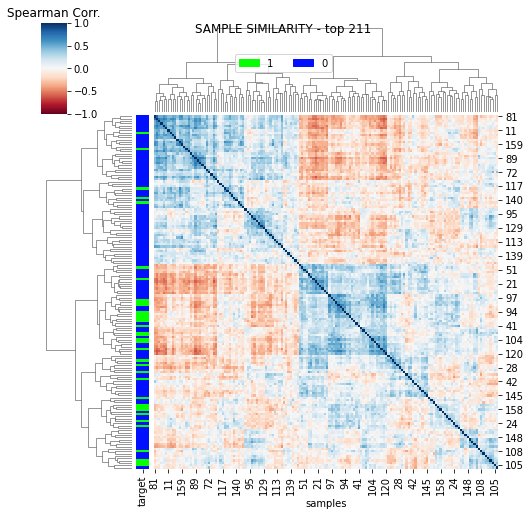

............................................................
GENE EXPRESSION IN THE TOP 
 211 differencially expressed genes
............................................................


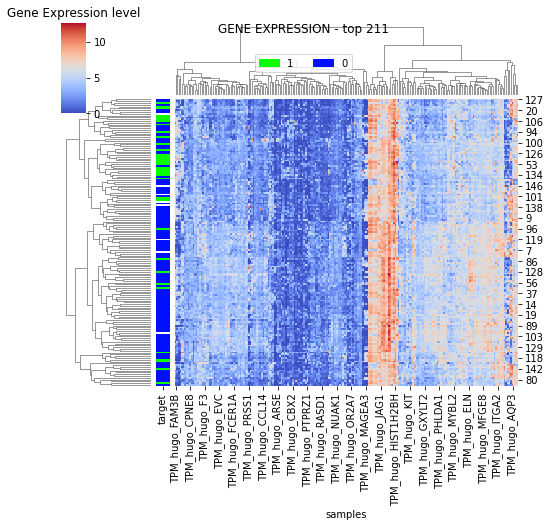

............................................................
PCA and tSNE analysis
............................................................


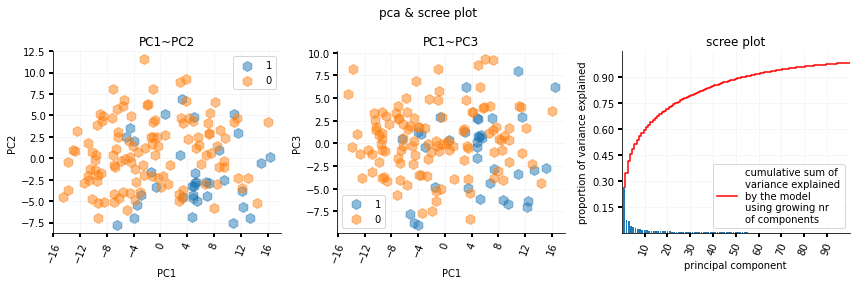


............................................................
 test0 - Step 1-5
............................................................



,input,log,log_filtered,log_filtered_scaled,outliers_removed,top_genes,after pca
sample nr,40,40,40,40,40,40,40
gene nr,31085,31085,18534,18534,18534,211,152
- VALUES -,,,,,,,
min tpm value recorded,0.0,0.0,0.0,-6.9,-6.9,-3.3,-10.1
median tpm value recorded,0.3,0.4,2.9,-0.0,-0.0,-0.0,0.0
mean tpm value recorded,32.2,1.8,3.1,0.1,0.1,0.0,0.0
max tpm value recorded,98876.1,16.6,16.6,155.9,155.9,10.2,10.2
- DETECTED IN -,,,,,,,
mean % of genes expressed per sample,59.9%,59.9%,95.7%,100.0%,100.0%,100.0%,100.0%
% of genes not expressed in any sample,22.8%,22.8%,0.0%,0.0%,0.0%,0.0%,0.0%



............................................................
 test1 - Step 1-5
............................................................



,input,log,log_filtered,log_filtered_scaled,outliers_removed,top_genes,after pca
sample nr,98,98,98,98,98,98,98
gene nr,31085,31085,18534,18534,18534,211,152
- VALUES -,,,,,,,
min tpm value recorded,0.0,0.0,0.0,-6.9,-6.9,-3.4,-12.4
median tpm value recorded,0.3,0.4,2.9,0.0,0.0,-0.0,0.0
mean tpm value recorded,32.2,1.8,3.1,0.1,0.1,0.1,0.0
max tpm value recorded,133685.0,17.0,17.0,171.3,171.3,14.0,11.1
- DETECTED IN -,,,,,,,
mean % of genes expressed per sample,60.4%,60.4%,96.1%,100.0%,100.0%,100.0%,100.0%
% of genes not expressed in any sample,19.6%,19.6%,0.0%,0.0%,0.0%,0.0%,0.0%


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  Signif_genes_PCA_v0__transf_data_dct.p
SAVED:  Signif_genes_PCA_v0__qc_reports_dct.p


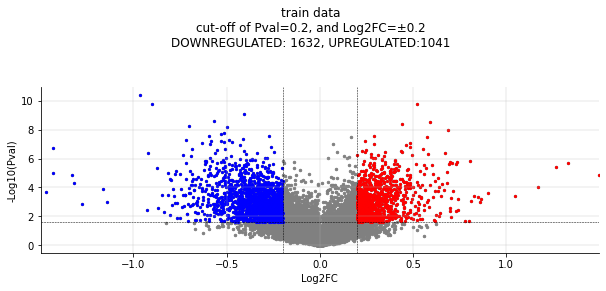


............................................................
 train - Step 1-5
............................................................



,input,log,log_filtered,log_filtered_scaled,outliers_removed,top_genes,after pca
sample nr,160,160,160,160,152,152,152
gene nr,31085,31085,18534,18534,18534,2673,152
- VALUES -,,,,,,,
min tpm value recorded,0.0,0.0,0.0,-8.7,-8.7,-5.2,-44.3
median tpm value recorded,0.3,0.4,2.9,-0.0,0.0,0.0,-0.0
mean tpm value recorded,32.2,1.8,3.1,0.1,0.1,0.1,0.0
max tpm value recorded,314419.1,18.3,18.3,336.7,336.7,171.1,147.0
- DETECTED IN -,,,,,,,
mean % of genes expressed per sample,60.1%,60.1%,95.9%,100.0%,100.0%,100.0%,100.0%
% of genes not expressed in any sample,18.2%,18.2%,0.0%,0.0%,0.0%,0.0%,0.0%


............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 2673 
differencially expressed genes
............................................................


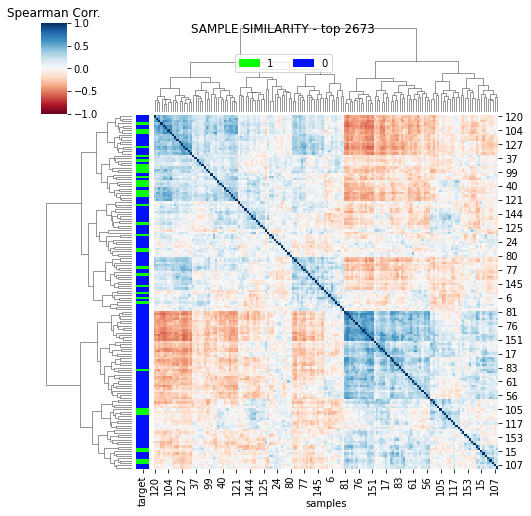

............................................................
GENE EXPRESSION IN THE TOP 
 2673 differencially expressed genes
............................................................


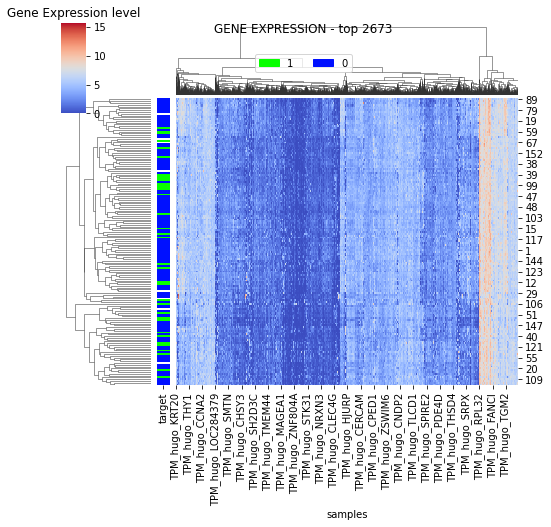

............................................................
PCA and tSNE analysis
............................................................


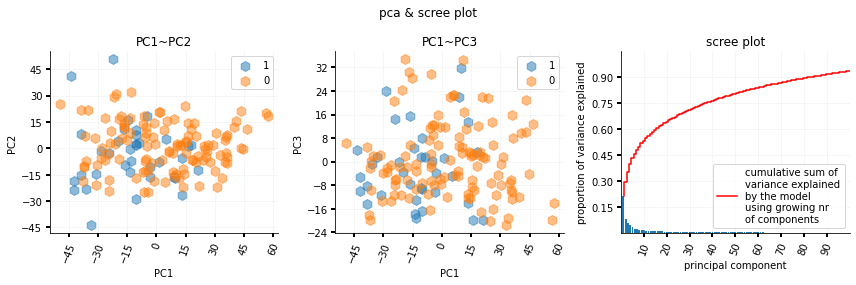


............................................................
 test0 - Step 1-5
............................................................



,input,log,log_filtered,log_filtered_scaled,outliers_removed,top_genes,after pca
sample nr,40,40,40,40,40,40,40
gene nr,31085,31085,18534,18534,18534,2673,152
- VALUES -,,,,,,,
min tpm value recorded,0.0,0.0,0.0,-6.9,-6.9,-4.5,-35.8
median tpm value recorded,0.3,0.4,2.9,-0.0,-0.0,-0.0,0.0
mean tpm value recorded,32.2,1.8,3.1,0.1,0.1,0.0,0.0
max tpm value recorded,98876.1,16.6,16.6,155.9,155.9,46.5,43.9
- DETECTED IN -,,,,,,,
mean % of genes expressed per sample,59.9%,59.9%,95.7%,100.0%,100.0%,100.0%,100.0%
% of genes not expressed in any sample,22.8%,22.8%,0.0%,0.0%,0.0%,0.0%,0.0%



............................................................
 test1 - Step 1-5
............................................................



,input,log,log_filtered,log_filtered_scaled,outliers_removed,top_genes,after pca
sample nr,98,98,98,98,98,98,98
gene nr,31085,31085,18534,18534,18534,2673,152
- VALUES -,,,,,,,
min tpm value recorded,0.0,0.0,0.0,-6.9,-6.9,-5.4,-41.4
median tpm value recorded,0.3,0.4,2.9,0.0,0.0,0.0,-0.0
mean tpm value recorded,32.2,1.8,3.1,0.1,0.1,0.1,-0.0
max tpm value recorded,133685.0,17.0,17.0,171.3,171.3,76.3,47.2
- DETECTED IN -,,,,,,,
mean % of genes expressed per sample,60.4%,60.4%,96.1%,100.0%,100.0%,100.0%,100.0%
% of genes not expressed in any sample,19.6%,19.6%,0.0%,0.0%,0.0%,0.0%,0.0%


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  DE_genes_PCA_v0__transf_data_dct.p
SAVED:  DE_genes_PCA_v0__qc_reports_dct.p


In [32]:
# create test/validation dataset

n = 40
path = PATH_data_interim
random_nr = 0

# . set seed
np.random.seed(random_nr)

# . create idx, for test/valid datasets
idx_list = list(range(target.shape[0]))
np.random.shuffle(idx_list)
valid_idx = idx_list[0:n]; print(len(train_idx))
train_idx = idx_list[n:200]; print(len(valid_idx))

# . hand made methods - I had some issues with indexes
data_genes_train = data_genes.iloc[train_idx,:]
data_genes_train.reset_index(inplace=True, drop=True)
target_train = target.iloc[train_idx]
target_train.reset_index(inplace=True, drop=True)
data_cov_train = data_cov.iloc[train_idx,:]
data_cov_train.reset_index(inplace=True, drop=True)

# . validation 
data_genes_valid = data_genes.iloc[valid_idx,:]
data_genes_valid.reset_index(inplace=True, drop=True)
target_valid = target.iloc[valid_idx]
target_valid.reset_index(inplace=True, drop=True)
data_cov_valid = data_cov.iloc[valid_idx,:]
data_cov_valid.reset_index(inplace=True, drop=True)

# . run preprocessing pipeline
for data_set_name in list(parameters.keys()):

    transf_data, qc_reports = data_preprocessing_pipeline(
        # ..
        x_train=data_genes_train,
        y_train=target_train,
        cov=data_cov_train,
        cov_data_preprocessor=preprocessor,
        # ..
        x_test_list = [data_genes_valid, data_genes_test],
        y_test_list = [target_valid, None],
        cov_list = [data_cov_valid, data_cov_test],
        # ...
        verbose=1, 
        make_hist=True, 
        **parameters[data_set_name]
        )  

    # save the results
    os.chdir(path)
    print("PWD: ", path)
    
    # . file name
    prefix = f'{data_set_name}_v{random_nr}'
    
    # . save pickle - its fast, but dont use if you dont trust 
    fname = f"{prefix}__transf_data_dct.p"
    with open(fname, 'wb') as file: # wb - write binary,
                pickle.dump(transf_data, file) 
    print("SAVED: ", fname)

    # . save pickle - its fast, but dont use if you dont trust 
    fname = f"{prefix}__qc_reports_dct.p"
    with open(fname, 'wb') as file: # wb - write binary,
                pickle.dump(transf_data, file) 
    print("SAVED: ", fname)
    

__Create custom function for detecting differencially expressed genes, between the two classe with tstudent test and foldchnage__
* I applied this, method, as the siples possible option, 
* it can be replaced at any moent with another method, 
* more informaiton on the topic can be found here:
    * "Detecting differentially expressed genes in heterogeneous diseases using half Student’s t-test" https://academic.oup.com/ije/article/39/6/1597/736515
    * "Robustness of differential gene expression analysis of RNA-seq" https://doi.org/10.1016/j.csbj.2021.05.040